In [1]:
import os.path
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib
import matplotlib.pyplot as plt # this is used for the plot the graph 
from matplotlib import patches
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts



import sklearn
if sklearn.__version__ >"0.2.1":
    from sklearn.model_selection import KFold
else:
    from sklearn.cross_validation import KFold # use for cross validation
    
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from scipy.signal import argrelextrema, resample


# time series
from datetime import datetime, timedelta

### Plotting params

In [2]:
sns.set(style="whitegrid") # set seaborn for pretty plots
#plt.rc('legend', fontsize=12) # legend fontsize

### Data munging functions
A bunch of helpers

In [3]:
# Renames columns to standard format listed above,
# Normalizes timestamps relative to 0 (instead of experiment start time),
# Fills NaNs, inverts force.
def clean(df):
    df.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
    if(df.iloc[0].timestamp > 0):
        df.timestamp -= df.iloc[0].timestamp
    df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)
    df.f = -df.f
    return df.fillna(0)

In [4]:
# Grabs rolling average with default lag of 300-points.
# You can set #points in rolling window with `window` param, and
# select whether to add the rolling average column to the given 
# dataframe with `add_col` param.
def ma(df, window=500, add_col=True):
    m = df.f.rolling(window=window).mean()
    if add_col:
        df['f_ra'] = m
        return df.fillna(0)
    return m

In [5]:
# Grabs minima and maxima.
# This is its own function only because this is an expensive operation.
# Note this function operates on the rolling average, not the raw force, to prevent noisy points from interfering.
def get_extrema(df, order=2000, ra=False):
    col = 'f_ra' if ra else 'f'
    maxima = argrelextrema(df[col].values, np.greater, order=order)
    minima = argrelextrema(df[col].values, np.less, order=order)
    return minima, maxima

In [6]:
# Labels cycles based on local (force) minima and maxima.
# Points not belonging to a valid cycle, e.g. at start and end of experiment,
# are labeled with <cycle# = -1>.
def label_cycles(df, minima, maxima, ax=None, abs_min=None, abs_max=None, plot_boxes=True):
    # Plot line connecting all minima, and another line connecting all maxima.
    if not ax:
        fig, ax = plt.subplots(figsize=(25, 6), nrows=1, ncols=1)
    if abs_min and abs_max:
        ax.plot(df.f, alpha=0.3)
        ax.plot(df.f.iloc[abs_max[0].tolist()], '--')
        ax.plot(df.f.iloc[abs_min[0].tolist()], '--')

    # Label cycles.
    df['cycle'] = -1
    for i in range(minima[0].size-1):
        rng = list(range(minima[0][i], minima[0][i+1]))
        df.iloc[rng, df.columns.get_loc('cycle')] = i # I don't know why `iloc` succeeds while `loc` fails here. I spent 1.5 hours on this bug.
  
    # Draw bounding boxes around each cycle.
    if plot_boxes:
        for i in minima[0].tolist():
            ax.add_patch(
                patches.Rectangle((i, df.f.min()), df[df.cycle==i].shape[0], df.f.max()-df.f.min(), linewidth=1, edgecolor='black', facecolor='none', alpha=0.2, linestyle=':')
            )
    df.cycle = df.cycle.astype(np.int64) # Just to be safe
    return df

### Run data munging

In [27]:
# X_100 is a dataset with estimated 100 cycles and conductive paste in silicon skin.
X100 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-11-16-21-07-24.msgpack"))), window=150)
X100.drop(columns=['mdia', 'msgtype', 'rc', 'rw'], inplace=True) # clean up unnecessary columns

In [7]:
X61 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-12-12-18-21-34.msgpack"))), window=150)
X61.drop(columns=['mdia', 'msgtype', 'rc', 'rw'], inplace=True) # clean up unnecessary columns

In [29]:
X61.head()

,f,pwm,t,t0,timestamp,f_ra
0,-0.459416,0.0,27.079405,26.040293,0.000000,0.0
1,-1.446461,0.0,27.079405,26.040293,0.019196,0.0
2,0.028283,0.0,27.078402,26.042980,0.038605,0.0
3,-0.449492,0.0,27.078402,26.042980,0.048553,0.0
4,-0.417416,0.0,27.078402,26.042980,0.058502,0.0


In [30]:
def plot_raw(df, n_cycles=103,savefig=None,figsize=(8, 4)):
    # one figure / two charts
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize,dpi=300,sharex=True)
    ax.flat[0].set_title('Raw measurements, %d cycles' % n_cycles)
#     x = np.arange(0,len(df))
    x = df.timestamp
    # top chart
    ax.flat[0].plot(x,df.pwm, c='r', alpha=1,lw=0.5, label='PWM')
    ax2 = ax.flat[0].twinx()
    ax2.plot(x,df.f, alpha=0.8,lw=0.5, label='Force'); 
    ax2.set_ylabel('Force [N]')
    ax.flat[0].legend(loc='best'); ax2.legend(loc='best')
    ax.flat[0].set_ylabel('PWM')
    # bottom chart
    ax.flat[1].plot(x,df.t,lw=0.5, label='Muscle temperature (C)'); 
    ax.flat[1].plot(x,df.t0,lw=0.5, label='Environment temperature (C)')
    ax.flat[1].legend(loc='best')
    ax.flat[1].set_ylabel('Temperature [°C]')
    ax.flat[1].set_xlabel('time [s]')
    plt.gca().set_xlim(left=0)
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig,dpi=300)
    plt.show()

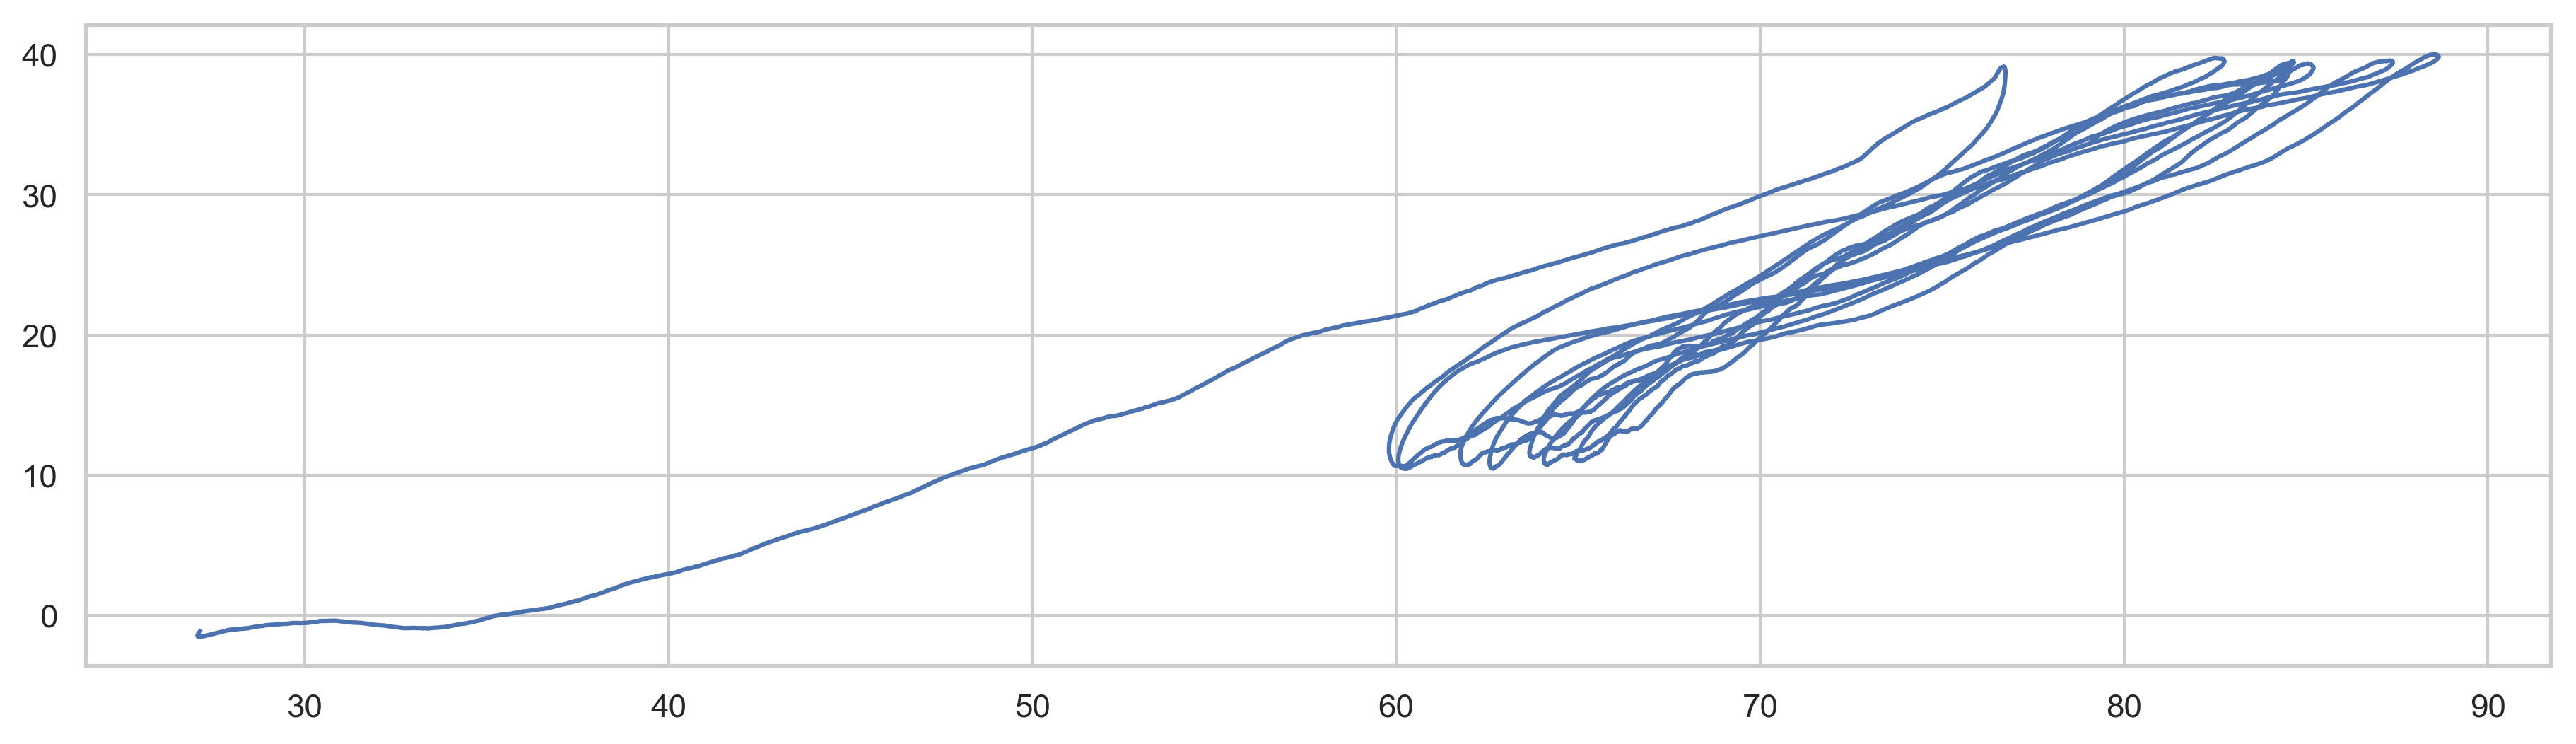

In [9]:
from scipy.signal import savgol_filter
plt.rcParams['agg.path.chunksize'] = 1000

def plot_temperature_difference_force(df):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 4),dpi=300)
    ax.plot(savgol_filter(df.t, 1001, 3),savgol_filter(df.f, 1001, 3))
plot_temperature_difference_force(X61[:100000])

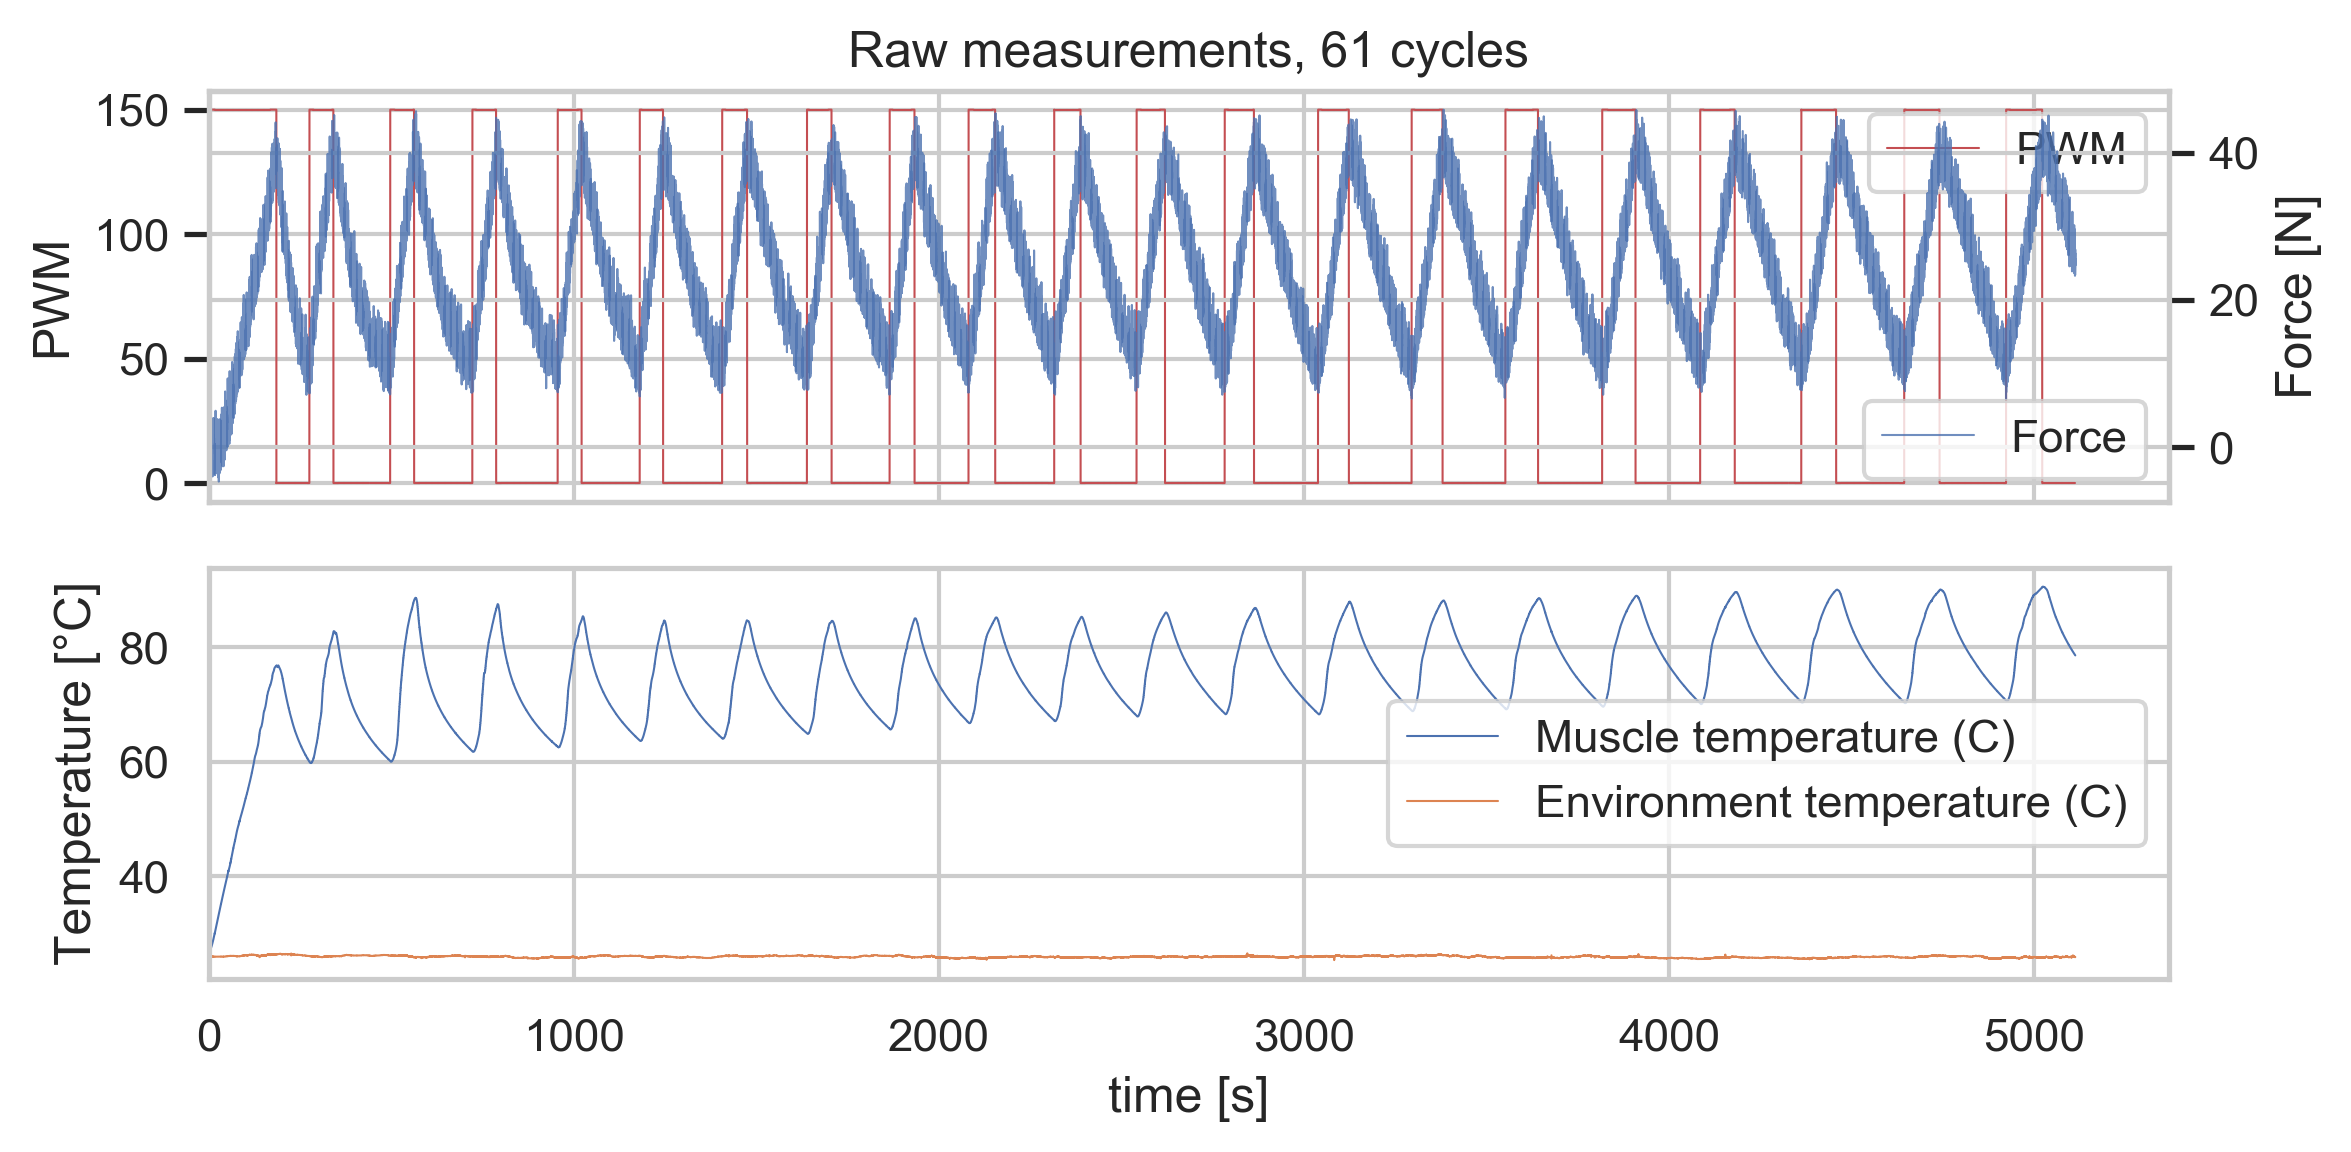

In [12]:
# plot_raw(X100, n_cycles=103)
plot_raw(X61[:295000], n_cycles=61,savefig='plots/raw measurement,61cycles.png')

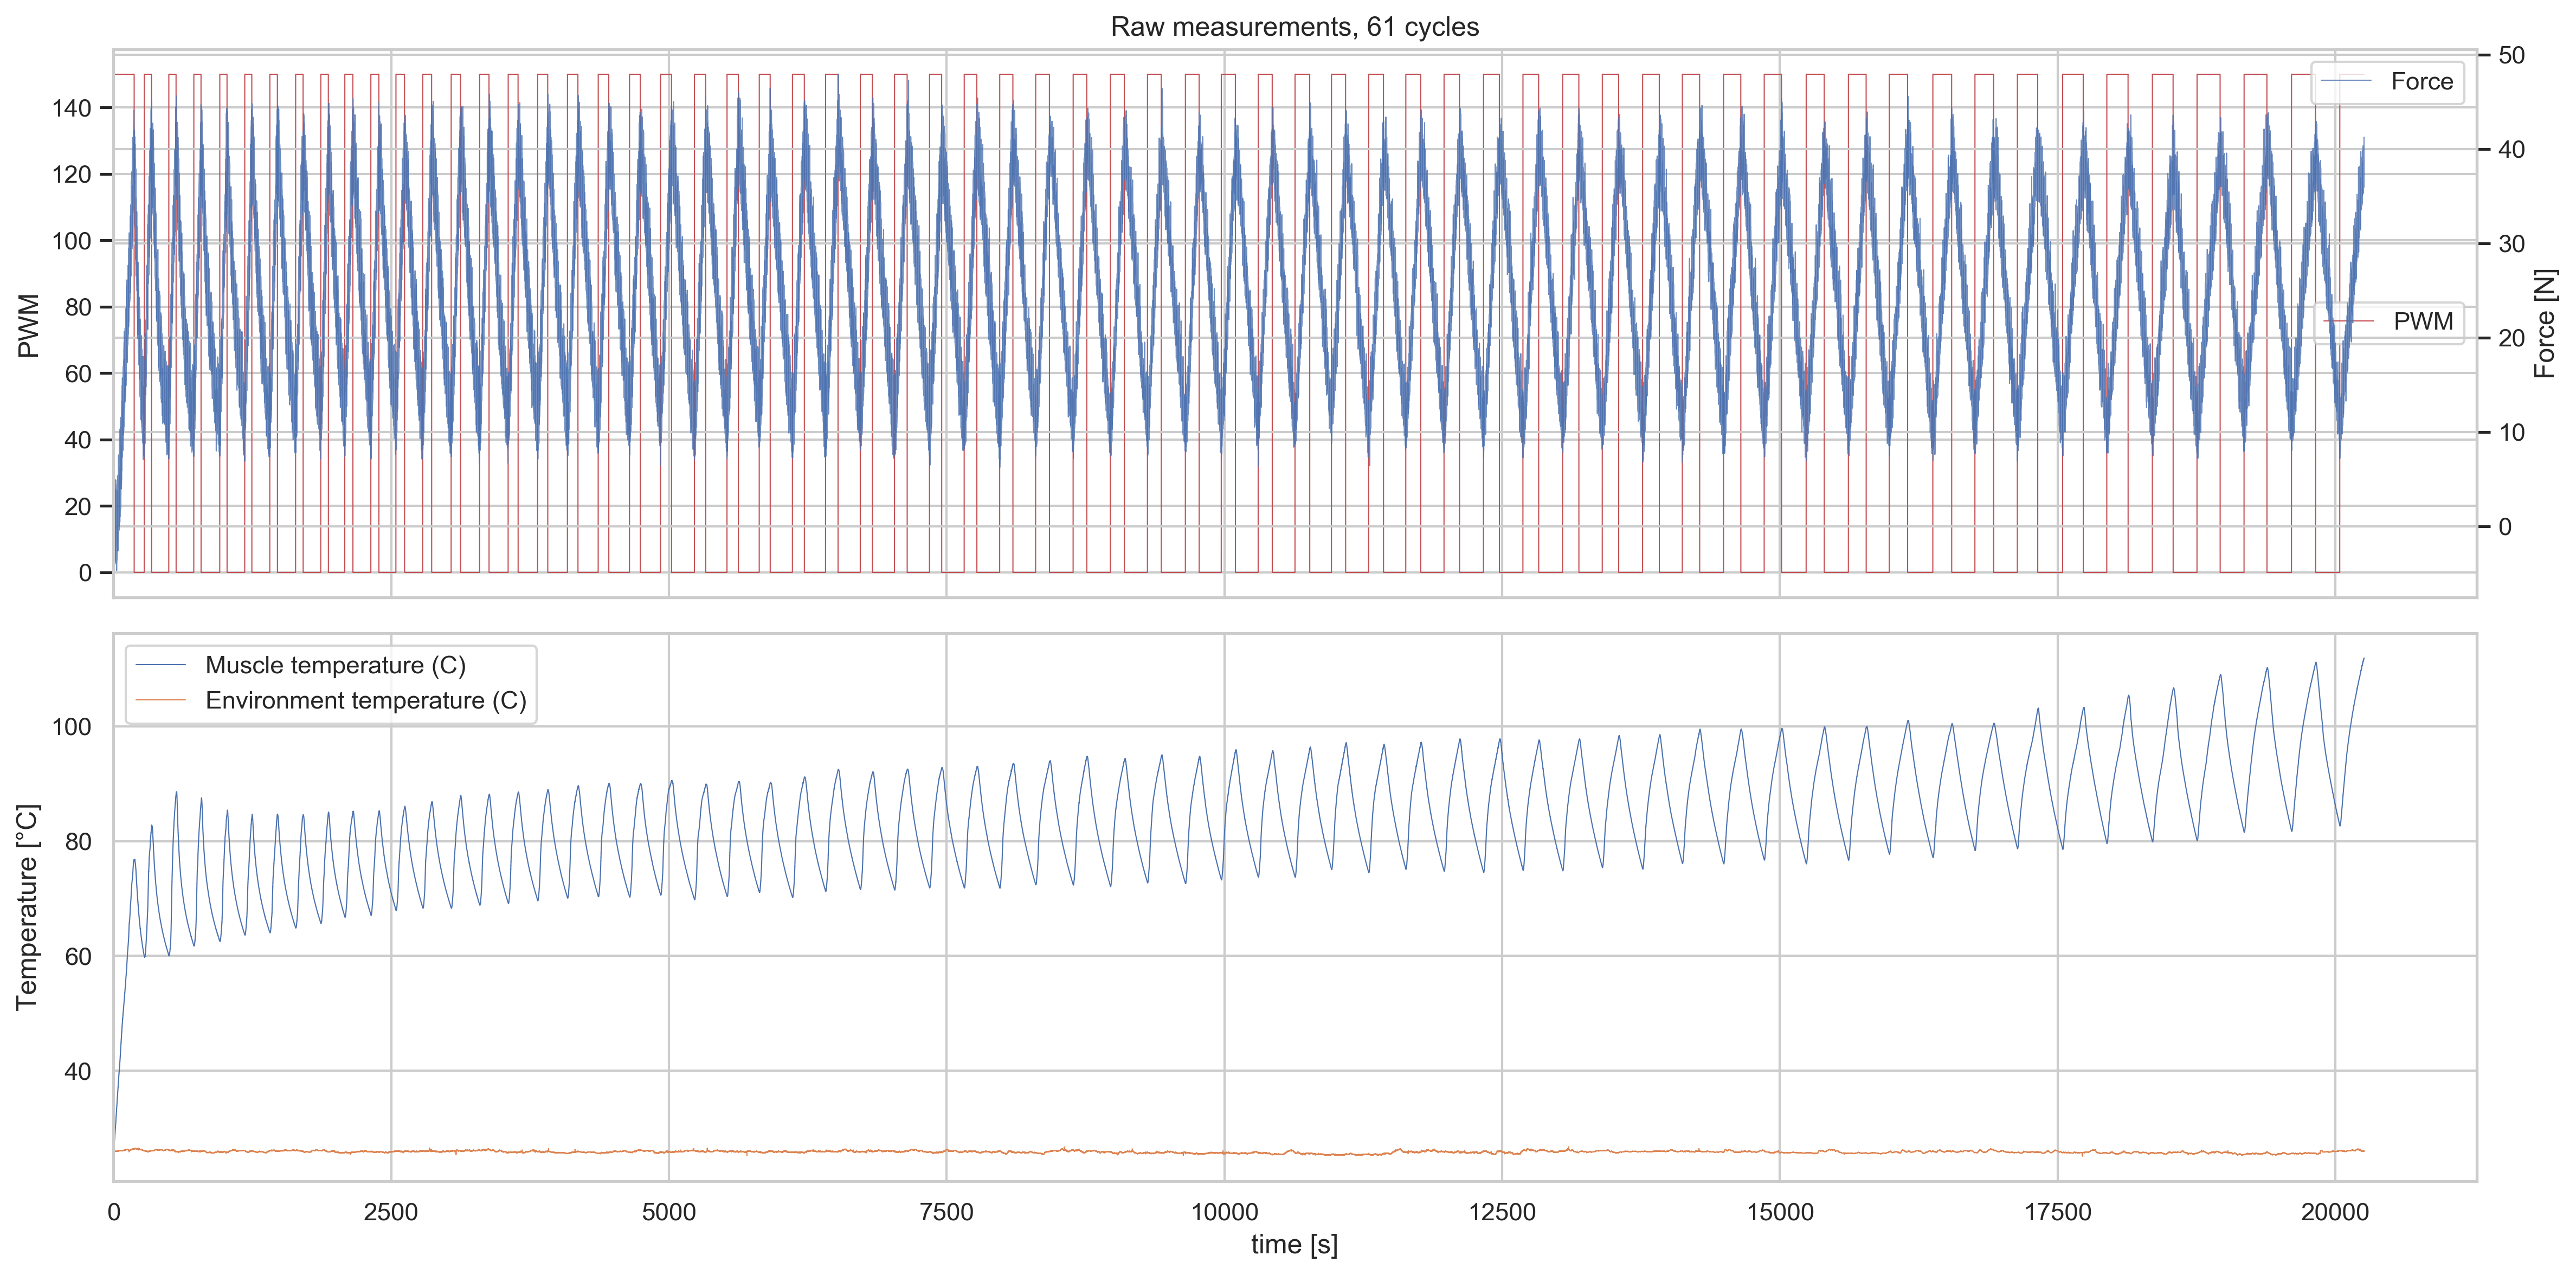

In [13]:
plot_raw(X61, n_cycles=61,savefig='plots/raw measurement,61cycles_all.png',figsize=(16, 8))

### Force-temperature correlation
Joint probabilities / Pearson correlation let us know whether a temperature-force relationship is worth investigating

In [31]:
def pickle_meta(df, name='df'):
    filename = 'meta_%s.pkl' % name
    # pickle data, if not already done so
    if not os.path.isfile(filename):
        minima, maxima = get_extrema(df, ra=True)
        abs_min, abs_max = get_extrema(df, order=3000, ra=False)
        df = label_cycles(df, minima, maxima, abs_min=abs_min, abs_max=abs_max)
        df.cycle = df.cycle.astype(np.int64)
        df_s, c_to_p = squash_periods(df)
        df_s.cycle = df_s.cycle.astype(np.int64)
        df.to_pickle(filename)
        df_s.to_pickle('meta_%sS.pkl' % name)

### 61-cycles normalized
Periods normalized to fixed $\Delta t$ using FFT.

In [32]:
RESET = False
if not os.path.isfile('d2.temp.pkl') or RESET:
    d2 = X61.copy()
    minima, maxima = get_extrema(d2, ra=True)
    abs_min, abs_max = get_extrema(d2, order=1500, ra=False)
    d2 = label_cycles(d2, minima, maxima, abs_min=abs_min, abs_max=abs_max)
    d2.cycle = d2.cycle.astype(np.int64)
    d2.to_pickle('d2.temp.pkl')

In [33]:
# Squashes periods down to a constant for all rows in a dataset.
# You can set the desired period with param `period`.
# If you don't, the function just chooses the shortest period.
def squash_periods(df, period=-1, plot_cycles=True):
    #ss.reset_orig()
    c_to_p = {} # maps cycles to their periods
    columns=["f", "pwm", "t", "t0", "f_ra", "cycle", "timestamp"]
    fig, ax = plt.subplots(figsize=(8, 6), nrows=1, ncols=1,dpi=300)
    df.cycle, X = df.cycle.astype(np.int64), pd.DataFrame(columns=columns)
        
    for c in range(df.cycle.max()):
        c_to_p[c] = df[df.cycle==c].shape[0]
    if period<0:
        period = int(min(c_to_p.values()))

    if not os.path.isfile('temp.pkl'):
        for c in range(df.cycle.max()):
            C = pd.DataFrame(resample(df[df.cycle==c], period), columns=columns)
            C.cycle = c
            X = pd.concat([X, C], ignore_index=True)
            if plot_cycles:
                ax.plot(np.linspace(0,1,len(C)),C.f_ra, color=plt.cm.RdYlBu(float(c)/df.cycle.max()))
        X.timestamp = df.timestamp.iloc[:X.timestamp.size,]
        X.to_pickle('temp.pkl')
    else:
        from scipy.signal import savgol_filter
        lastmax = 0
        X = pd.read_pickle('temp.pkl')
        for c in range(X.cycle.max()):
            C = pd.DataFrame(resample(df[df.cycle==c], period), columns=columns)
            C.cycle = c
            #print C.f_ra.min(), C.f_ra.max()
            
            yhat = savgol_filter(C.f, 1001, 3)
            ax.plot(np.linspace(0,1,len(C)),yhat, color=plt.cm.RdYlBu(float(c)/X.cycle.max()))
            #lastmax = C.f_ra.max()
    
    ax.set_xlabel('Normalized Time')
    ax.set_ylabel('Force [N]')
    ax.set_xlim([0,1])
    if plot_cycles:
        cmap = plt.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=0, vmax=df.cycle.max()),
            cmap=plt.get_cmap('RdYlBu', df.cycle.max())
        )
        cmap.set_array([])
        plt.colorbar(cmap, orientation="horizontal", pad=0.1,ax=ax,label='cycle#')
        
    plt.tight_layout()    
    
#     plt.show()
    plt.savefig('plots/normalzied force.png',dpi=300)
    return X, c_to_p

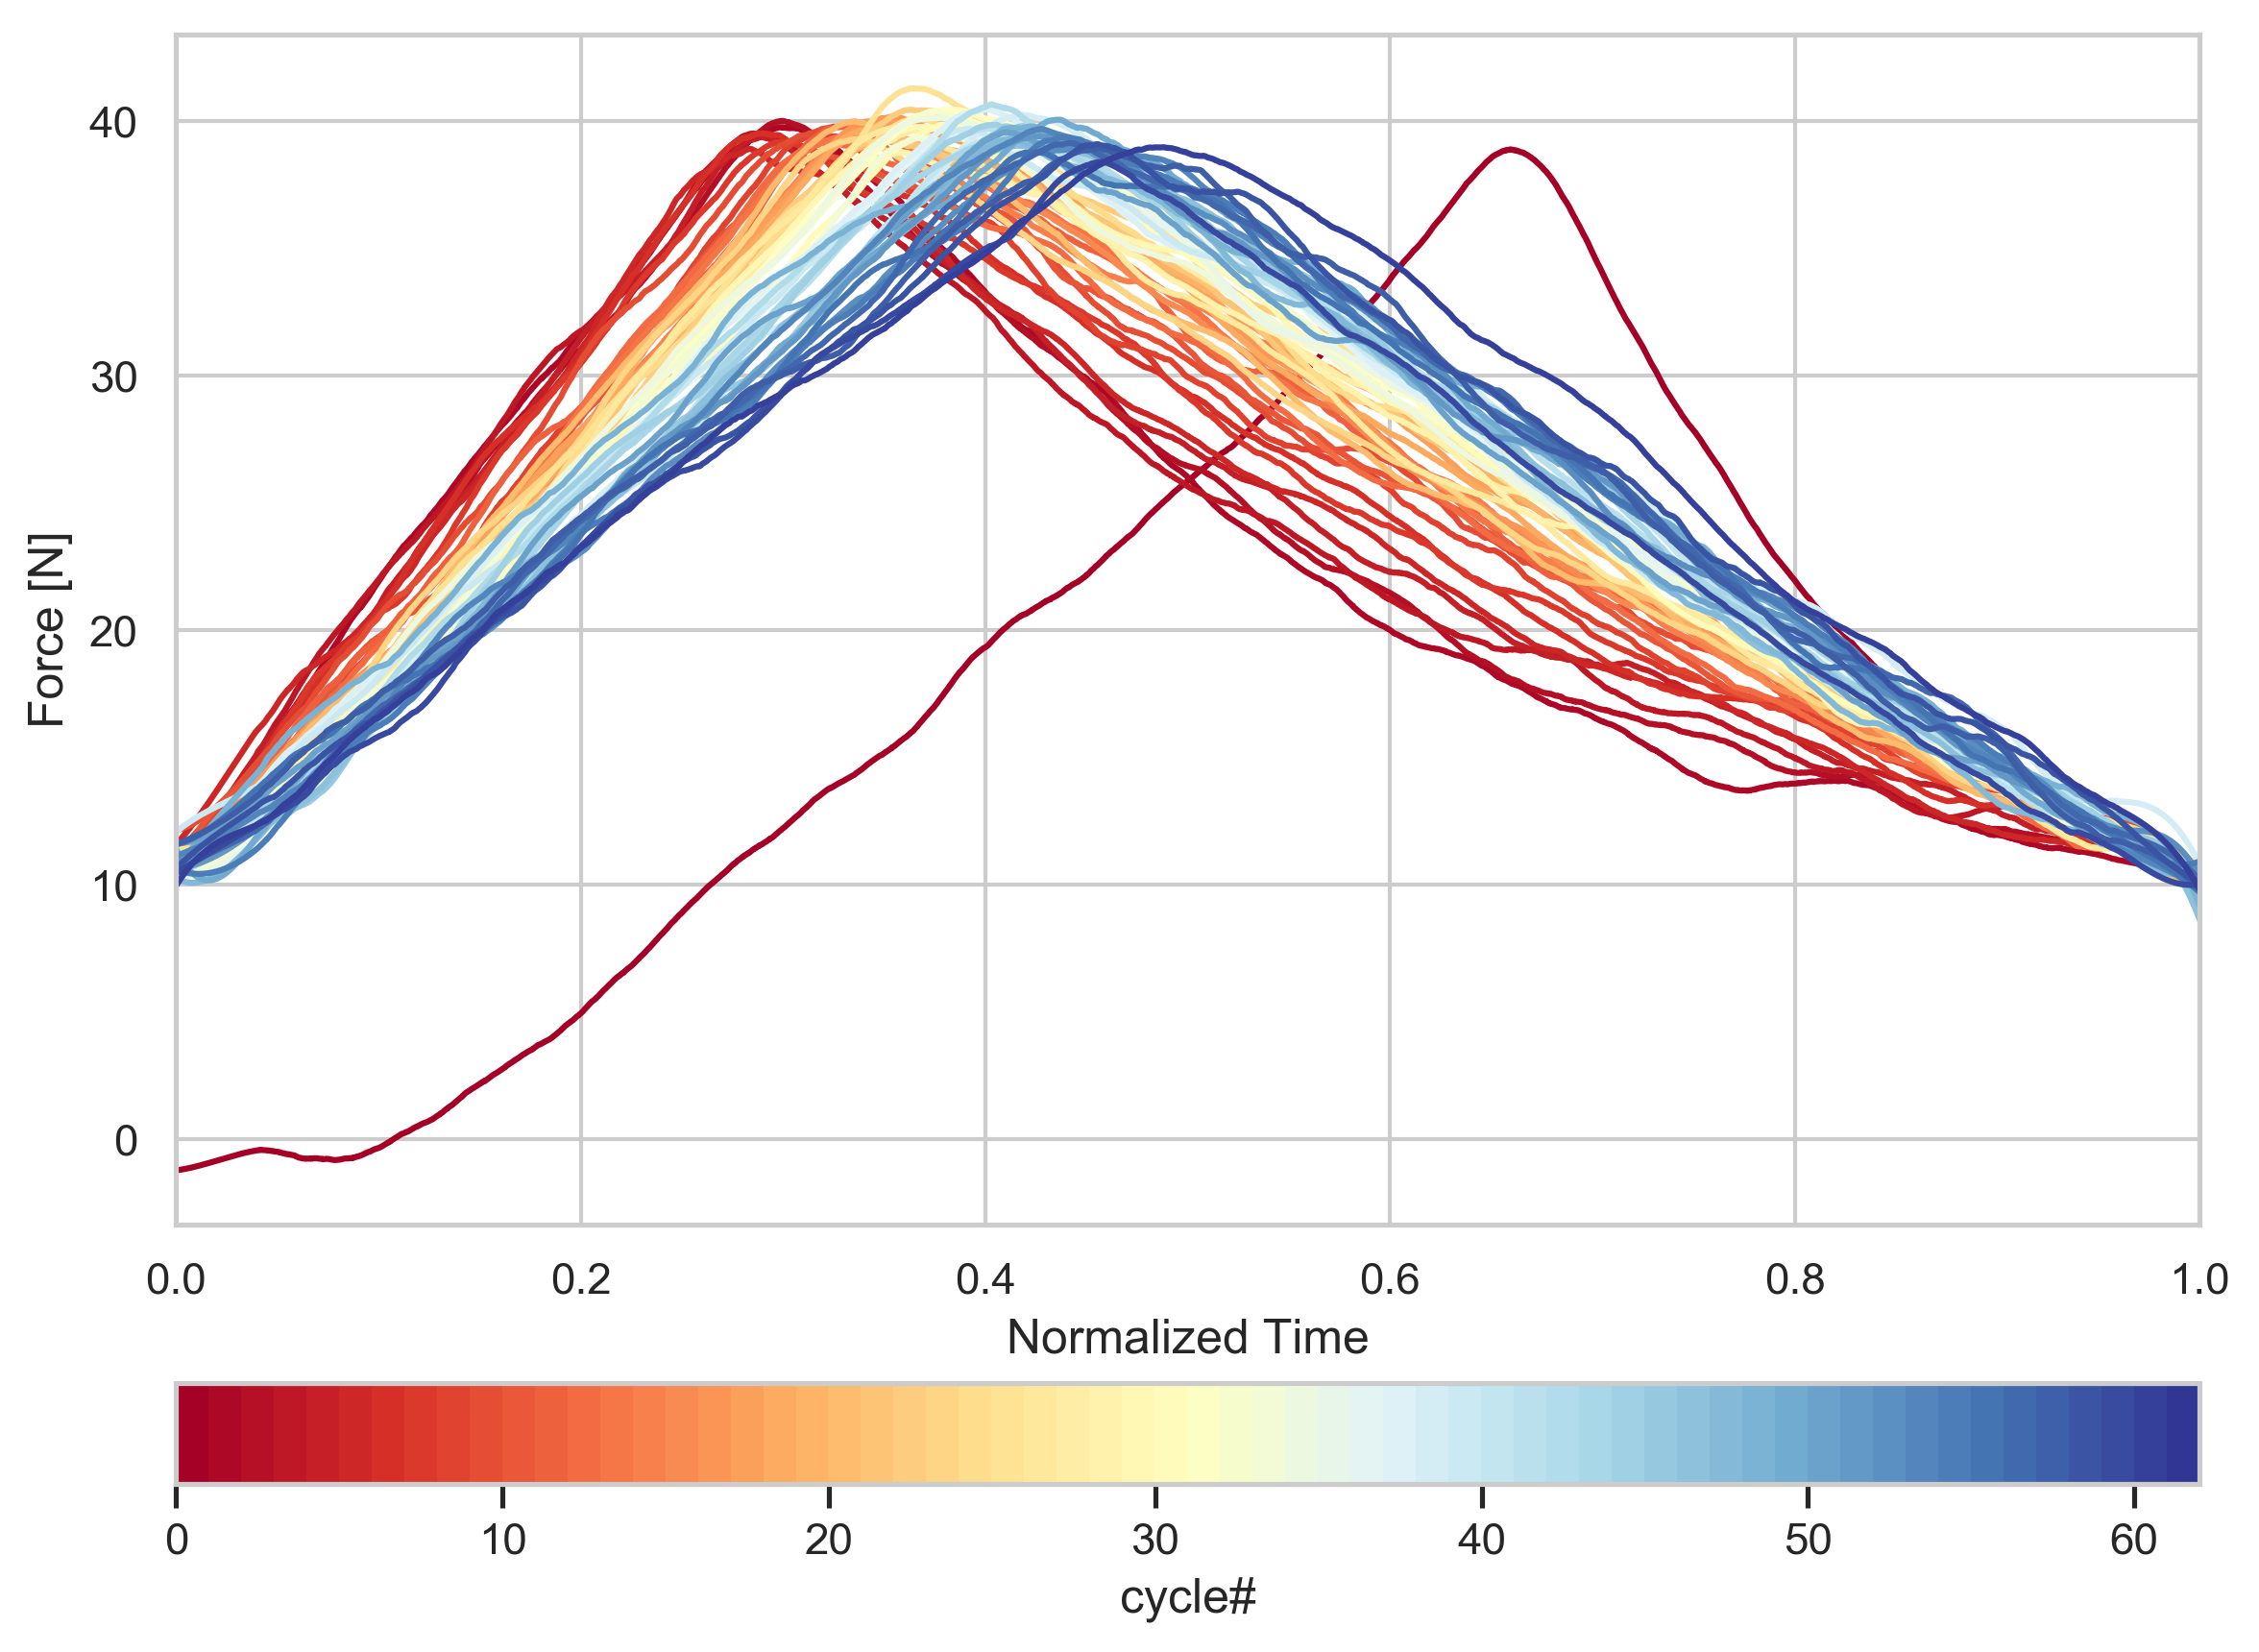

In [34]:
d2 = pd.read_pickle('d2.temp.pkl')
d2.cycle = d2.cycle.astype(np.int64)
d2_s, c_to_p= squash_periods(d2)

In [35]:
pickle_meta(X100, name='X100')
pickle_meta(X61, name='X61')

## Joint plots
We smooth force using a simple rolling average over a 1500ms time window:
$$
f_{ra} = \frac{f_{t_i-1500ms} + \dots + f_{t_i}}{n}
$$
where $n=150$ is the number of samples collected from time $t_i-1500ms$ to time $t_i$. The joint probability of smoothed force observations against temperature are pictured below. With Pearson's $\rho=0.95$ and $\rho=0.81$ we conclude that smoothed force and temperature are strongly correlated ($p<<1$). Thus we attempt to model force in response to temperature, timestamp, PWM, and previous force factors.

In [67]:
def ft_corr(df, df_s):
    if type(df.timestamp.iloc[0,]) != pd._libs.tslibs.timestamps.Timestamp: # convert to datetime timestamp, if necessary
        df.timestamp = df.timestamp.map(lambda t: datetime.fromtimestamp(t));
        df = df.set_index(pd.DatetimeIndex(df.timestamp), inplace=False);
    df_s.set_index(pd.DatetimeIndex(df_s.timestamp.map(lambda t: datetime.fromtimestamp(t))), inplace=True);
    season = int((df_s[df_s.cycle==1].shape[0])/0.1) #ms
    h = sns.jointplot(x=df_s.resample('%dL' % season).mean().t,\
              y=df_s.resample('%dL' % season).mean().f_ra, ratio=10)
    ax = h.ax_joint
#     ax.set_ylabel('Temperature [°C]')
#     ax.set_xlabel('Force[N]')
    
    plt.tight_layout()
    plt.savefig('plots/jointplots_temperature_vs_force.png',dpi=300)
    return df, df_s

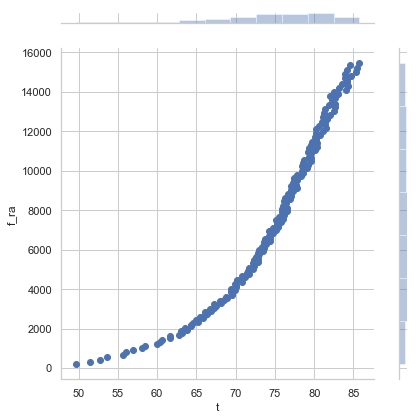

In [50]:
unpickled_df, unpickled_df_s = pd.read_pickle('meta_X100.pkl'), pd.read_pickle('meta_X100S.pkl')
X100, X100S = ft_corr(unpickled_df, unpickled_df_s)

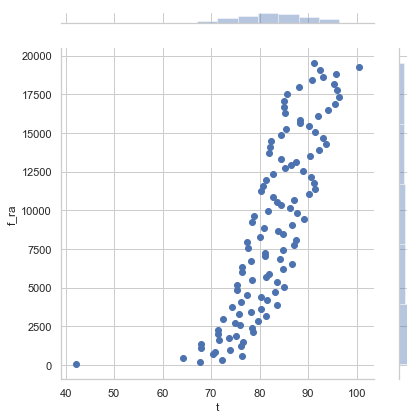

In [69]:
unpickled_df, unpickled_df_s = pd.read_pickle('meta_X61.pkl'), pd.read_pickle('meta_X61S.pkl')
X61, X61S = ft_corr(unpickled_df, unpickled_df_s)

### Train-test split

In [8]:
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential, model_from_json
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


Using TensorFlow backend.


In [11]:
def train_val_test_split(df, ratio=0.8):
    if 'cycle' in df.columns:
        data = df.drop(columns=['cycle'], inplace=False)
    else:
        data = df.copy()
    data = np.apply_along_axis(lambda row: np.reshape(row, (1,-1)), 1, data.drop(columns=['timestamp']).values)
    train_cutoff, val_cutoff = int(ratio*ratio * data.shape[0]), int(ratio * data.shape[0])
    train, val, test = data[:train_cutoff,], data[train_cutoff:val_cutoff,], data[val_cutoff:,]
    train_X, train_y = train[:,:,1:], train[:,:,0].flatten()
    val_X, val_y = val[:,:,1:], val[:,:,0].flatten()
    test_X, test_y = test[:,:,1:], test[:,:,0].flatten()
    print("TRAIN_X: ", train_X.shape, " TRAIN_Y: ", train_y.shape)
    print("VAL_X: ", val_X.shape, " VAL_Y: ", val_y.shape)
    print("TEST_X: ", test_X.shape, " TEST_Y: ", test_y.shape)
    return train_X, train_y, val_X, val_y, test_X, test_y

### Supported so far:
`train_X, train_y, test_X, test_y = train_test_split(X61)`

`train_X, train_y, test_X, test_y = train_test_split(X103)`

In [64]:
df = X61
df[['pwm','t','t0','f_ra']].values

array([[  0.        ,  27.07940483,  26.04029274,   0.        ],
       [  0.        ,  27.07940483,  26.04029274,   0.        ],
       [  0.        ,  27.07840157,  26.04298019,   0.        ],
       ...,
       [150.        , 111.91593933,  25.95174599,  38.3168277 ],
       [150.        , 111.91777802,  25.95443916,  38.31006816],
       [150.        , 111.91777802,  25.95443916,  38.31819845]])

In [65]:
X61.head()

,f,pwm,t,t0,timestamp,f_ra
0,-0.459416,0.0,27.079405,26.040293,0.000000,0.0
1,-1.446461,0.0,27.079405,26.040293,0.019196,0.0
2,0.028283,0.0,27.078402,26.042980,0.038605,0.0
3,-0.449492,0.0,27.078402,26.042980,0.048553,0.0
4,-0.417416,0.0,27.078402,26.042980,0.058502,0.0


In [10]:
train_X, train_y, val_X, val_y, test_X, test_y = train_val_test_split(X61)

KeyError: "['cycle'] not found in axis"

In [11]:
710906/(710906+177726+222159)

0.6399997839377525

In [15]:
222159/(710906+177726+222159)

0.20000072020749177

In [16]:
1.2*250

300.0

In [73]:
train_X

array([[[  0.        ,  27.07940483,  26.04029274,   0.        ]],

       [[  0.        ,  27.07940483,  26.04029274,   0.        ]],

       [[  0.        ,  27.07840157,  26.04298019,   0.        ]],

       ...,

       [[150.        ,  86.16122437,  26.29768181,  17.34016682]],

       [[150.        ,  86.16122437,  26.29768181,  17.33352489]],

       [[150.        ,  86.16794586,  26.3001461 ,  17.33759256]]])

### LSTM
Time-series/sequential problem. Framing this as a supervised learning problem:

At time $t_i$, 

__given__:

1. sequence of temperature values $ T $ at time $(t_{i-k}) \dots (t_{i})$, $k>0$,
2. sequence of force values (N) $f$ at time $(t_{i-k}) \dots (t_{i-1})$, $k>0$,
3. sequence of rolling-average force values (N) $f_{ra}$ at time $(t_{i-k}) \dots (t-{i-1})$, $k>0$,
4. PWM input at time $t_i$,

__predict__: $f$ at $t_i$

We feed as inputs both raw force $f$ and smoothed force $f_{ra}$ and do not risk data leakage, because $f_{ra}$ always legs behind $f$. We feed the model both features in order to inject prior knowledge about the force signal: raw force measurements provide a noisy high-frequency signal, so we attempt to approximate a seasonal time-series component using smoothing.

We use mean squared error (MSE) as a loss metric:
$$
MSE = \frac{1}{2n}\sum_x \left\lVert y(x) - \hat{y}(x) \right\rVert ^ 2
$$
for a force estimate $\hat{y}(x)$ given parameters listed above at time $t_i$. The MSE loss function is commmonly used in deep learning, as it punishes large errors, preserves the units of the data, and can be computed easily.

Our model generates a rolling time-series forecast of force with high accuracy.

In [3]:
name = 'X61'

In [4]:
def load_model(name):
    # load json and create model
    json_file = open('%s.json' % name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights('%s.h5' % name)
    return loaded_model
model = load_model(name)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [83]:
def save_model(model, name='X100'):
#     if not os.path.isfile('%s.json' % name) or not os.path.isfile('%s.h5' % name):
    model_json = model.to_json()
    with open('%s.json' % name, 'w') as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('%s.h5' % name)
    model.save('%s.hdf5' % name)
# save_model(model, name='X61')

### Run model

In [50]:
from keras.layers import CuDNNLSTM

In [77]:
def train(name, start_over=False): # set start_over=True if you want to retrain the model & overwrite all weights
    if not os.path.isfile('%s.hdf5' % name) or start_over:
        model = Sequential()
        model.add(CuDNNLSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(32))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        history = model.fit(train_X, train_y, epochs=20, batch_size=10000,\
                            validation_data=(val_X, val_y), verbose=2, shuffle=True)
        save_model(model, name)
    else:
        model = load_model(name) ###?
        history = None
    return model,history

In [78]:
model,history = train('X61', start_over=True)

Train on 710906 samples, validate on 177726 samples
Epoch 1/20
 - 1s - loss: 391.6154 - val_loss: 90.0978
Epoch 2/20
 - 1s - loss: 50.0951 - val_loss: 4.5887
Epoch 3/20
 - 1s - loss: 25.2951 - val_loss: 1.6251
Epoch 4/20
 - 1s - loss: 22.8232 - val_loss: 2.3163
Epoch 5/20
 - 1s - loss: 22.1764 - val_loss: 2.3348
Epoch 6/20
 - 1s - loss: 21.9622 - val_loss: 2.2648
Epoch 7/20
 - 1s - loss: 21.8670 - val_loss: 1.5776
Epoch 8/20
 - 1s - loss: 21.7522 - val_loss: 1.6700
Epoch 9/20
 - 1s - loss: 21.6690 - val_loss: 2.0586
Epoch 10/20
 - 1s - loss: 21.6153 - val_loss: 1.9920
Epoch 11/20
 - 1s - loss: 21.5722 - val_loss: 1.4461
Epoch 12/20
 - 1s - loss: 21.5264 - val_loss: 1.7241
Epoch 13/20
 - 1s - loss: 21.5490 - val_loss: 1.8189
Epoch 14/20
 - 1s - loss: 21.4541 - val_loss: 2.5114
Epoch 15/20
 - 1s - loss: 21.5390 - val_loss: 2.4065
Epoch 16/20
 - 1s - loss: 21.4304 - val_loss: 2.1528
Epoch 17/20
 - 1s - loss: 21.4055 - val_loss: 1.6177
Epoch 18/20
 - 1s - loss: 21.3513 - val_loss: 1.9004
E

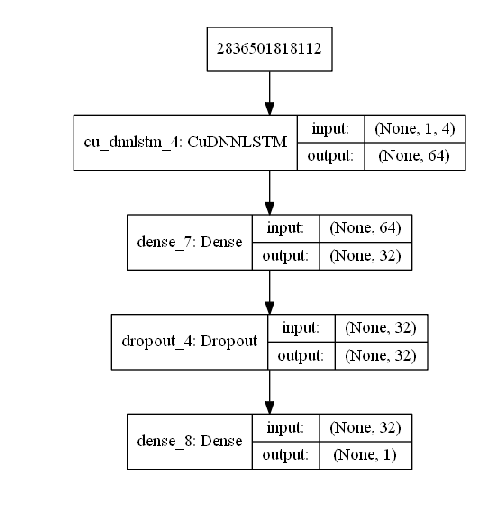

In [7]:
image_path = 'plots/model.png'
keras.utils.plot_model(model, 
                       show_shapes=True,
                       to_file=image_path)
plt.figure(dpi=150)
imgplot = plt.imshow(plt.imread(image_path))
plt.axis('off')
plt.show()

In [35]:
!pip install pydot

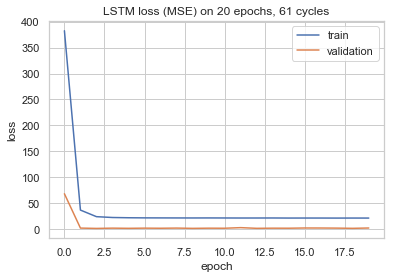

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss (MSE) on %d epochs, %d cycles' % (20, 61))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [39]:
yhat = model.predict(val_X)

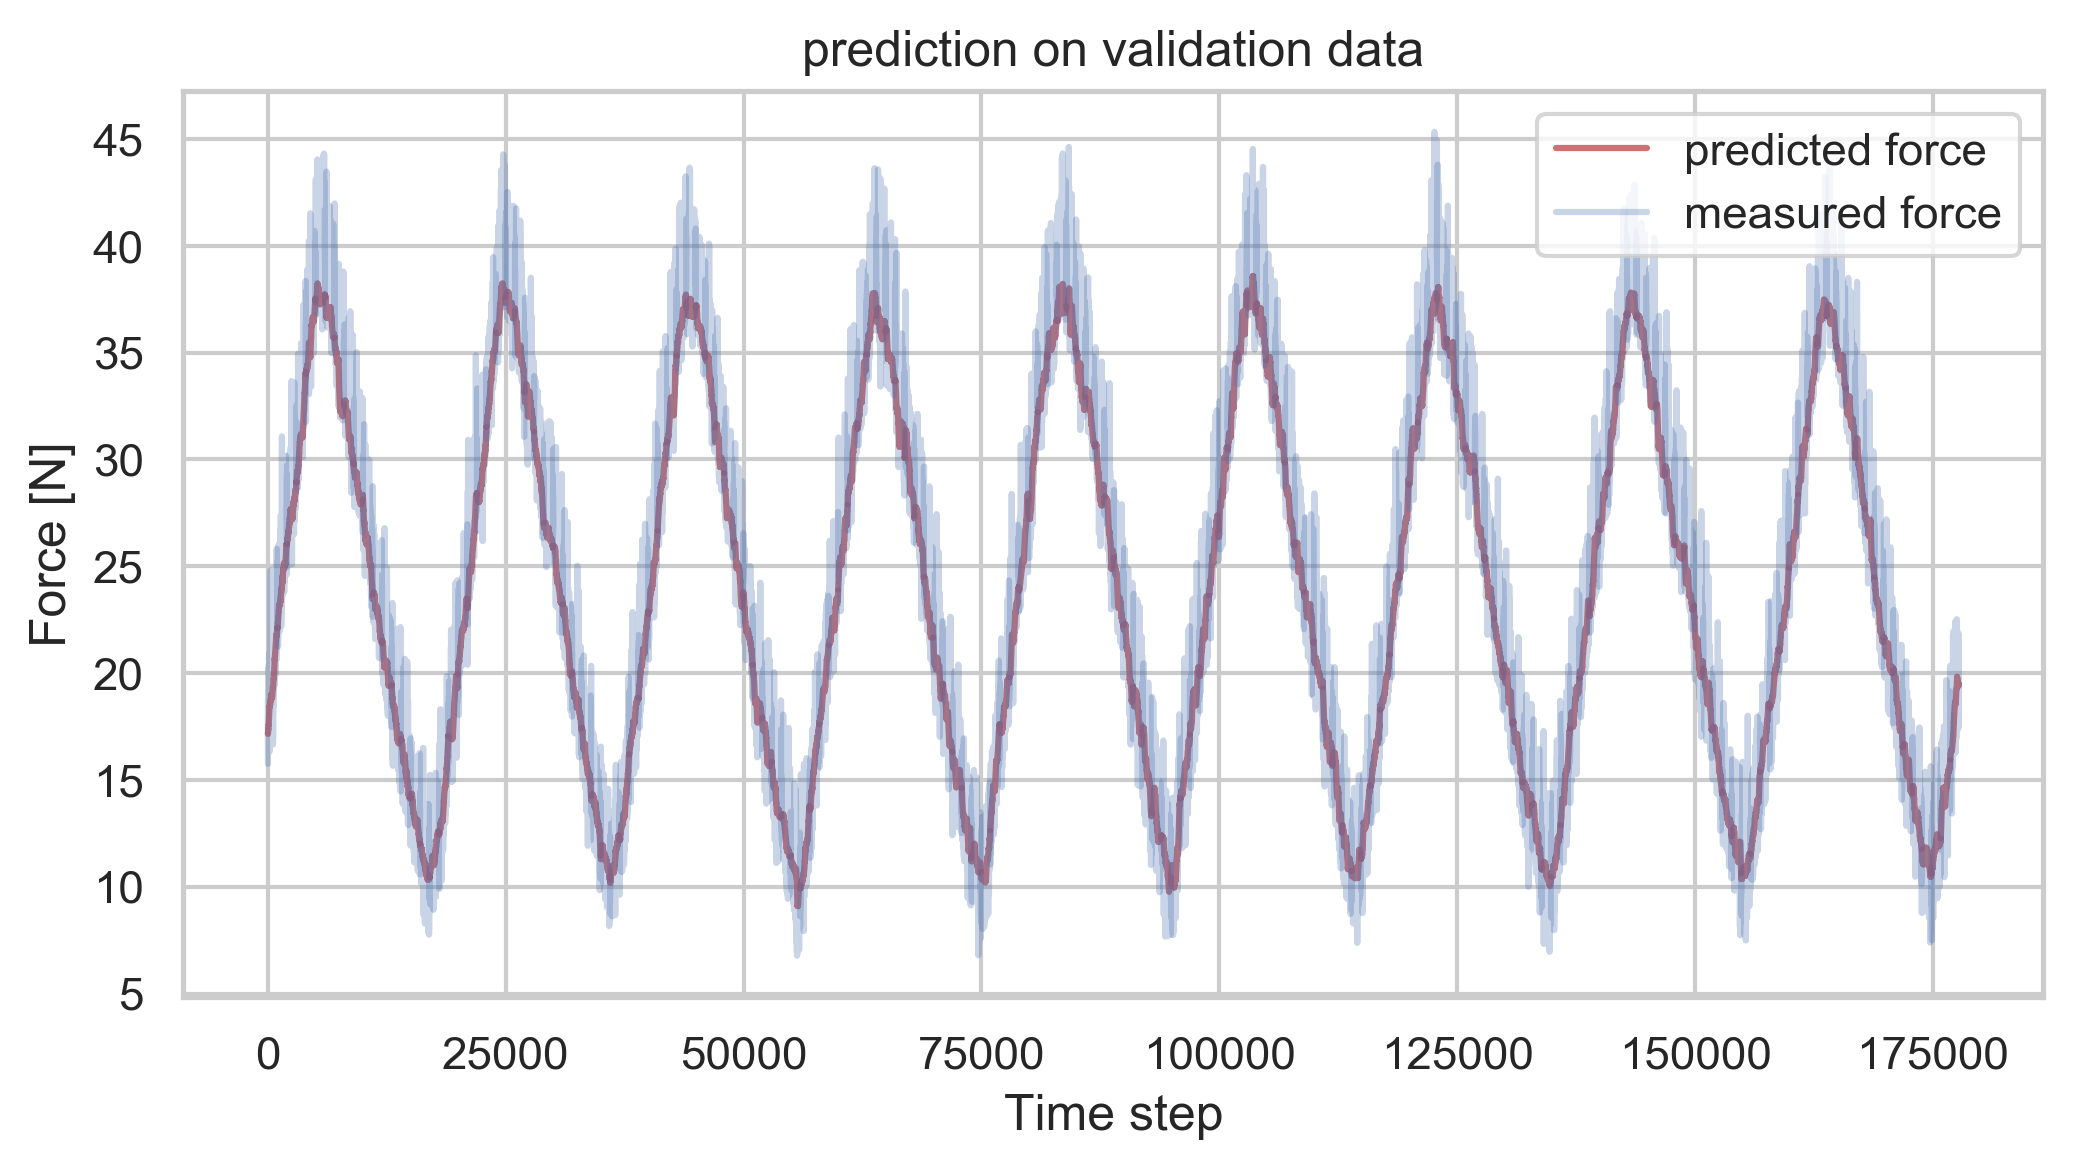

In [40]:
fig, ax = plt.subplots(figsize=(8,4),dpi=300)
ax.plot(yhat, alpha=0.8, c='r', label='predicted force')
ax.plot(val_y, alpha=0.3, c='b', label='measured force')
ax.set_title('prediction on validation data')
ax.set_xlabel('Time step')
ax.set_ylabel('Force [N]')

plt.legend()
plt.savefig('plots/prediction on validation data.png',dpi=300)

plt.show()

In [41]:
yhat = model.predict(test_X)

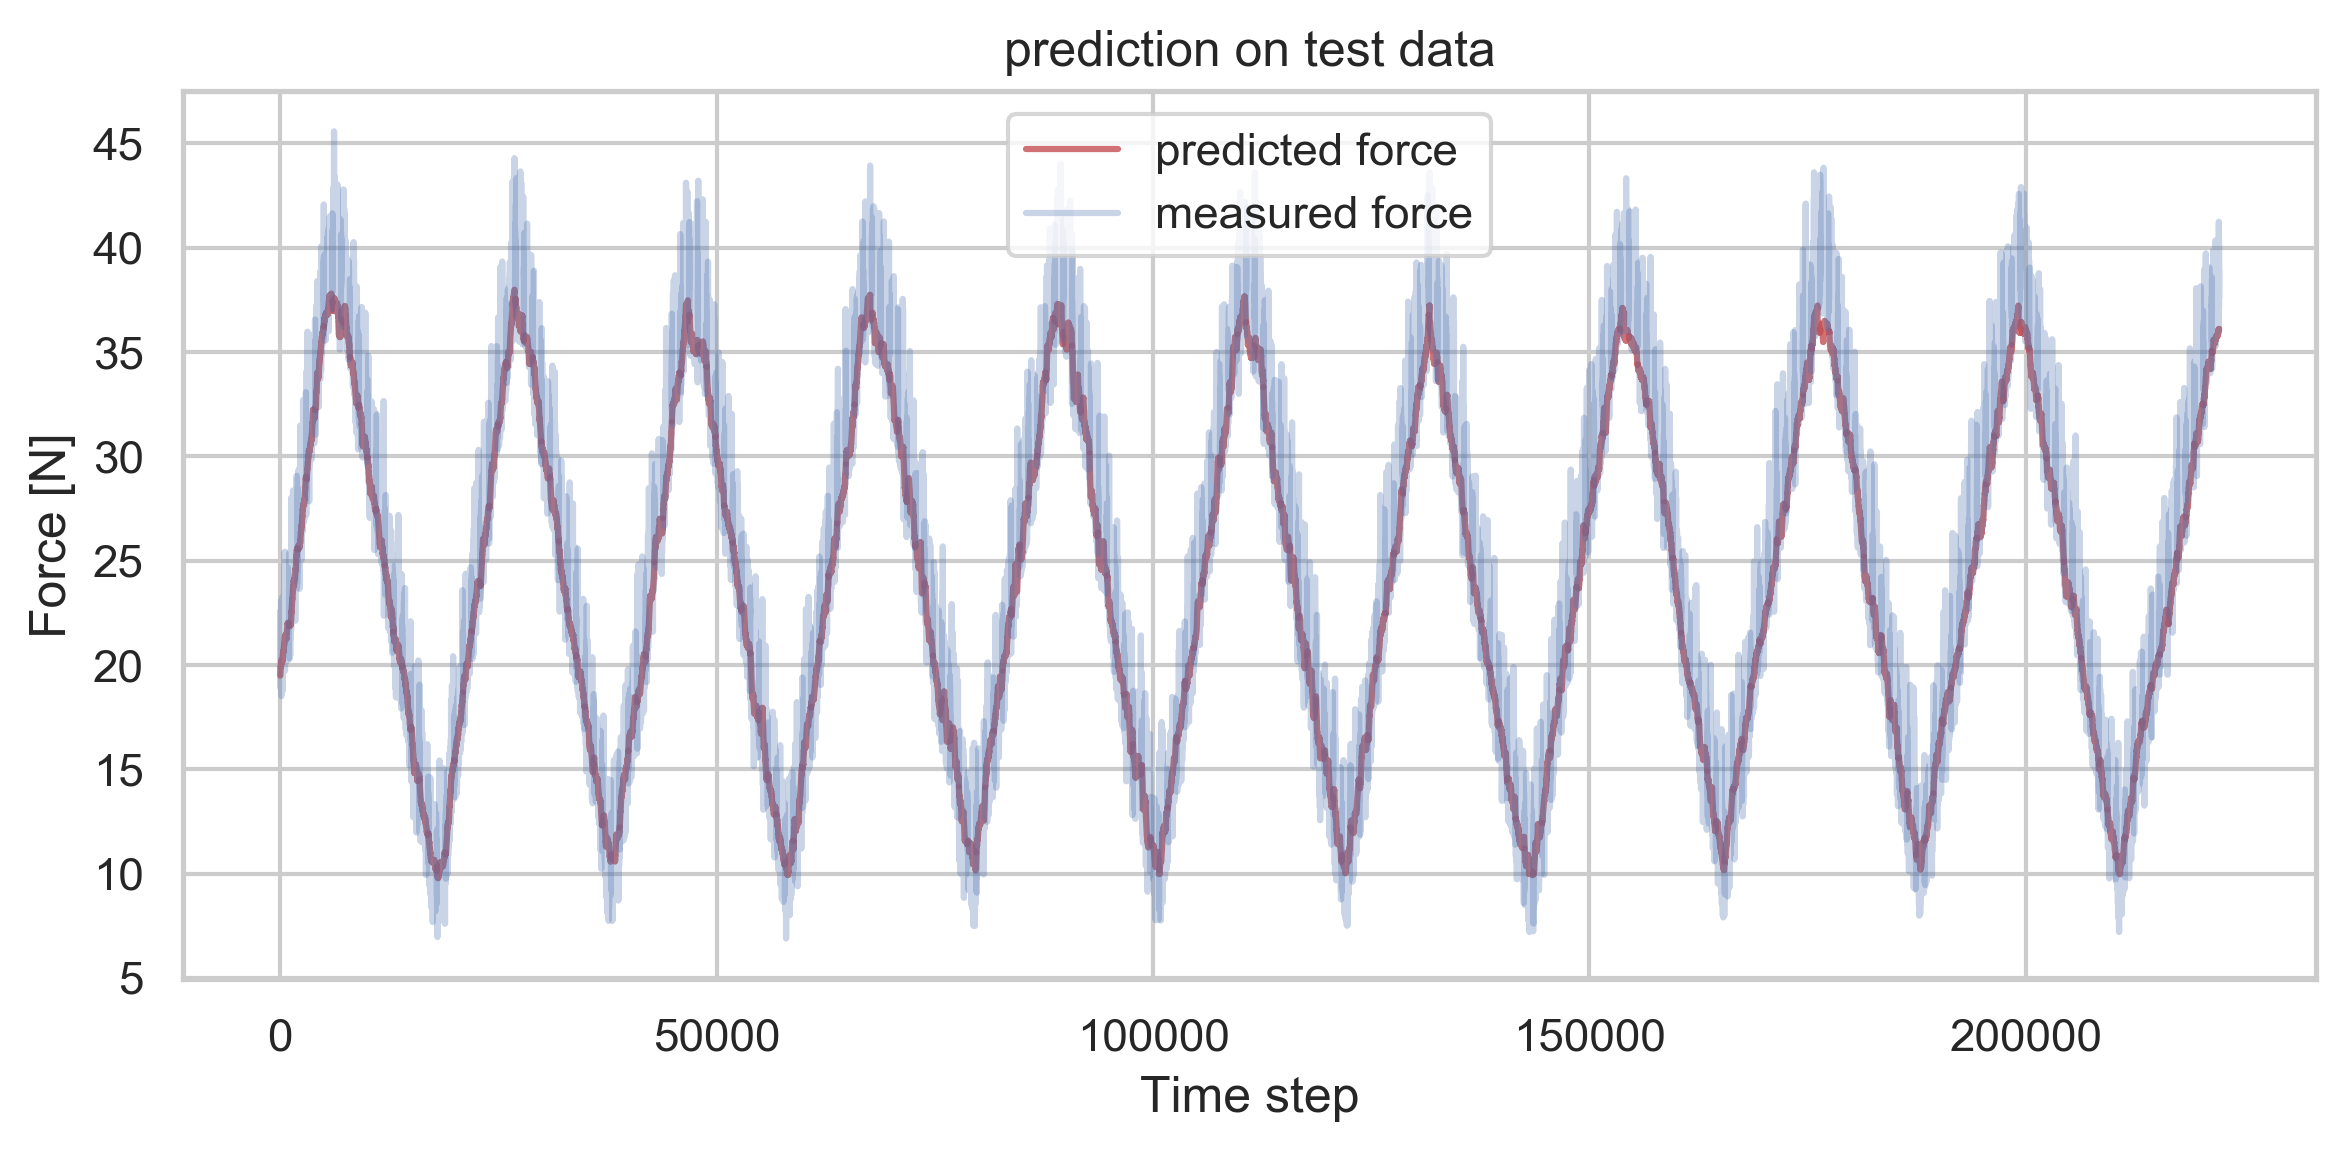

In [42]:
fig, ax = plt.subplots(figsize=(8,4),dpi=300)
ax.plot(yhat, alpha=0.8, c='r', label='predicted force')
ax.plot(test_y, alpha=0.3, c='b', label='measured force')

ax.set_title('prediction on test data')
ax.set_xlabel('Time step')
ax.set_ylabel('Force [N]')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('plots/prediction on test data.png',dpi=300)
plt.show()